In [2]:
from lstm_model import build_open_loop_lstm, load_open_loop_lstm
from data_processing import create_training_split, df_training_split, train_valid_test_split, df_train_valid_test_split, create_df_3d, create_window_closed_loop, add_new_pred, compute_lyapunov_time_arr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime, time
import tensorflow_datasets as tfds
import tensorflow as tf
import lstm_model
import importlib
import Feedback_Model
import data_processing
import plots
plt.rcParams["figure.facecolor"] = "w"
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
importlib.reload(Feedback_Model)

<module 'feedback_tf_example' from '/Users/eo821/Documents/PhD_research/Lorenz_LSTM/feedback_tf_example.py'>

In [3]:
mydf = np.genfromtxt('CSV/Lorenz_trans_001.csv', delimiter=',')
time = mydf[0, :]
mydf = mydf[1:, :]
print("Shape of discrete time step array ", time.shape)
print("Shape of solution array: ", mydf.shape)
df_train, df_valid, df_test = df_train_valid_test_split(mydf)
time_train, time_valid, time_test = train_valid_test_split(time)
x_train, x_valid, x_test = train_valid_test_split(mydf[0, :])
y_train, y_valid, y_test = train_valid_test_split(mydf[1, :])
z_train, z_valid, z_test = train_valid_test_split(mydf[2, :])
window_size = 50
batch_size = 32
shuffle_buffer_size = df_train.shape[0]
train_dataset = create_df_3d(df_train.transpose(), window_size, batch_size, shuffle_buffer_size)
valid_dataset = create_df_3d(df_valid.transpose(), window_size, batch_size, 1)
test_dataset = create_df_3d(df_test.transpose(), window_size, batch_size, 1)

Shape of discrete time step array  (18000,)
Shape of solution array:  (3, 18000)


In [4]:
# only take first element of dataset
for data, labels in train_dataset.take(1):
    numpy_data = data.numpy()
    numpy_labels = labels.numpy()
    

2022-02-18 10:19:22.550624: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [5]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=5)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
history = model_oloop.fit(train_dataset, epochs=100, batch_size=batch_size,
                          validation_data=valid_dataset, callbacks=[tensorboard_callback])  # , early_stop_callback])

NameError: name 'model_oloop' is not defined

In [5]:
def custom_loss(y_true, y_pred, washout=0):
    mse = tf.keras.losses.MeanSquaredError()
    # (batchsize, dimensions)
    loss = mse(y_true[washout:, :], y_pred[washout:, :])
    return loss

In [6]:
feedback_model = Feedback_Model.FeedBack(units=10)

In [85]:
feedback_model.fit(train_dataset, epochs=10, batch_size=32,
                   validation_data=valid_dataset, verbose=2)

Epoch 1/10
336/336 - 4s - loss: 0.0359 - mse: 0.0359 - mean_squared_error: 0.0000e+00 - val_loss: 0.0092 - val_mse: 0.0092 - val_mean_squared_error: 0.0000e+00 - 4s/epoch - 11ms/step
Epoch 2/10
336/336 - 3s - loss: 0.0048 - mse: 0.0048 - mean_squared_error: 0.0000e+00 - val_loss: 0.0023 - val_mse: 0.0023 - val_mean_squared_error: 0.0000e+00 - 3s/epoch - 9ms/step
Epoch 3/10
336/336 - 3s - loss: 0.0013 - mse: 0.0013 - mean_squared_error: 0.0000e+00 - val_loss: 9.0743e-04 - val_mse: 9.0743e-04 - val_mean_squared_error: 0.0000e+00 - 3s/epoch - 9ms/step
Epoch 4/10
336/336 - 3s - loss: 5.6668e-04 - mse: 5.6668e-04 - mean_squared_error: 0.0000e+00 - val_loss: 6.0041e-04 - val_mse: 6.0041e-04 - val_mean_squared_error: 0.0000e+00 - 3s/epoch - 9ms/step
Epoch 5/10
336/336 - 3s - loss: 3.5603e-04 - mse: 3.5603e-04 - mean_squared_error: 0.0000e+00 - val_loss: 4.3719e-04 - val_mse: 4.3719e-04 - val_mean_squared_error: 0.0000e+00 - 3s/epoch - 9ms/step
Epoch 6/10
336/336 - 3s - loss: 2.4573e-04 - mse:

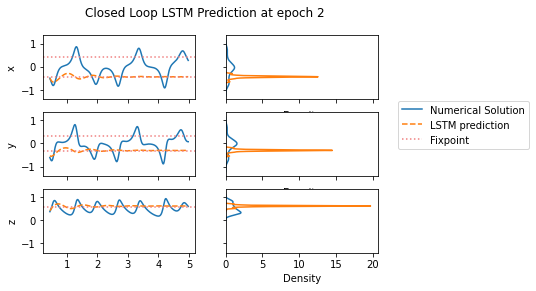

In [79]:
pred = plots.plot_closed_loop_lya(
    feedback_model,
    2,
    time_test,
    df_test,
    img_filepath=None,
    n_length=500,
    window_size=50,
)

In [80]:
n_epochs = 0 + 100
n_batches = 180
cloop_size = 32 * n_batches
test_window, labels, idx = lstm_model.select_random_batches_with_label(
    df_train.transpose(), n_batches
)
predictions = feedback_model.predict(np.array(test_window).reshape(cloop_size, 50, 3))
cloop_windows, cloop_label = lstm_model.add_cloop_prediction(
    df_train.transpose(), idx, np.array(predictions).reshape((cloop_size, 1, 3))
)
cloop_dataset = tf.data.Dataset.from_tensor_slices((cloop_windows, cloop_label.reshape(cloop_size,3)))

In [81]:
cloop_dataset = cloop_dataset.padded_batch(32, padded_shapes=([None, 3], [None]))

In [83]:
feedback_model.train_cloop(train_dataset, cloop_dataset, 5, 2, valid_dataset)

Epoch 0.000, Loss: 1.60E-01,  Cloop Loss: 1.60E-01, Metrics: 1.42E-01, Val_Loss: 3.86E-01, Val_Metrics: 3.86E-01
Time of this epoch:  3.517606019973755
Epoch 2.000, Loss: 1.55E-01,  Cloop Loss: 1.55E-01, Metrics: 1.38E-01, Val_Loss: 3.74E-01, Val_Metrics: 3.74E-01
Time of this epoch:  3.522641181945801
Epoch 4.000, Loss: 1.51E-01,  Cloop Loss: 1.51E-01, Metrics: 1.34E-01, Val_Loss: 3.61E-01, Val_Metrics: 3.61E-01
Time of this epoch:  3.4831149578094482


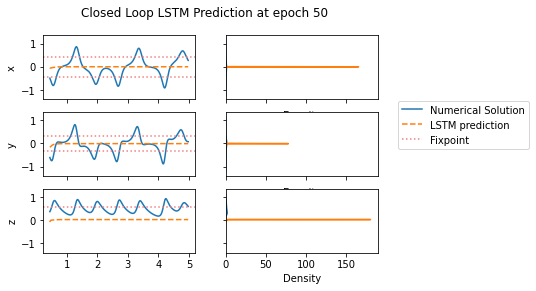

In [84]:
pred = plots.plot_closed_loop_lya(
    feedback_model,
    50,
    time_test,
    df_test,
    img_filepath=None,
    n_length=500,
    window_size=50,
)